In [3]:
import numpy as np
from scipy import stats
import networkx as nx
from networkx.algorithms import tree

## Statistic utils

### Genereate mean and cov for multi-variate normal distribtion with r_in and r_out

In [4]:
def get_mean_cov(num_clusters = 2, cluster_size = 50, r_in = 1, r_out = 0):
    vertex_count = num_clusters * cluster_size
    mean = np.zeros(vertex_count)
    r_ins = np.full((cluster_size, cluster_size), r_in)
    r_outs = np.full((cluster_size, cluster_size), r_out)
    cov = np.block([[np.tile(r_outs,k),r_ins,np.tile(r_outs,num_clusters-k -1)]  for k in range(num_clusters)])
    np.fill_diagonal(cov,1)
    return mean, cov


### Compute correlation matrix from passed covariance matrix.


In [5]:
def get_cor_from_cov(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

### Samples generator

In [6]:
def generate_samples_bag(mean, cov, bags = 10, sample_size = 50, distribution = np.random.multivariate_normal):
    return np.hsplit(distribution(mean, cov, sample_size * bags).T, bags)

#this function is required since networkx does not link vertices with zero weigth
#TODO - remove this solutiuion as it slightly moves distribution if zero is in sample
def set_zero_weights_to_very_low(adj_matrixes, value = 1e-6):
    adj_matrixes[adj_matrixes < value] = value
    return adj_matrixes

def get_corr_estimate(sample, corr_estimator = stats.pearsonr):
    vertex_count = sample.shape[0]
    corr_estimate = np.ones((vertex_count, vertex_count))
    for i in range(vertex_count):
        for j in range(i + 1, vertex_count):
            corr, _ = corr_estimator(sample[i], sample[j])
            corr = abs(corr)
            corr_estimate[i][j] = corr
            corr_estimate[j][i] = corr
    
    return corr_estimate



### Example: samples bag generation

**true_graph** - is an adjacency matrix equal to origin correlation matrix from considered multi-variate distribution with mean and cov parameters.

**samples_bag** - is a set of samples generated from considered distribution.

**estimated_graphs** - is a set of adjecency matrices created via correlation estimation from corresponding sample. 


In [7]:
mean, cov = get_mean_cov(num_clusters = 2, cluster_size = 5, r_in = 1, r_out = 0.2)
true_graph = get_cor_from_cov(cov)
set_zero_weights_to_very_low(true_graph)
samples_bag = generate_samples_bag(mean, cov, bags = 10, sample_size=10)
estimated_graphs = [set_zero_weights_to_very_low(get_corr_estimate(sample)) for sample in samples_bag]


## Algorithm API

Input:

*  **graph** - *adjacency matrix represented via numpy array with shape* ($|V|$, $|V|$). Input graph shall follow **completeness** property that is no zero values in the adjacency matrix.
*  **num_clusters** - *integer*

Output: 

*   **labels** - *numpy int array*

Example:  
Two connected vertices are partitioned into two clusters.
```
print(algo(np.array([1, 0.5], [0.5, 1]), num_clusters = 2))  
-> [0, 1]
```

## Algorithms

### Threshold Clustering

In [8]:
def get_community_labels(G):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)
    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def get_community_labels_from_less_cc(G, num_clusters):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)

    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def get_unique_thresholds(adj_matrix):
    tvs = adj_matrix.copy()
    tvs = tvs.reshape(tvs.shape[0] * tvs.shape[1])
    tvs = np.sort(tvs)
    tvs = np.unique(tvs)
    return tvs

def threshold_clustering(adj_matrix, num_clusters):
    adj_matrix_ = adj_matrix.copy()
    tvs = get_unique_thresholds(adj_matrix_)
    k = 0
    for k in range(tvs.shape[0]):
        adj_matrix_prev = adj_matrix_.copy()
        adj_matrix_[adj_matrix_ < tvs[k]] = 0
        G = nx.from_numpy_array(adj_matrix_)
        num_components = nx.number_connected_components(G)
        if num_components < num_clusters:
            continue
        elif num_components == num_clusters:
            return get_community_labels(G)
        else: 
            for i in range(adj_matrix_prev.shape[0]):
                for j in range(adj_matrix_prev.shape[0]):
                    if (adj_matrix_prev[i][j] < tvs[k] and adj_matrix_prev[i][j] != 0):
                        adj_matrix_prev[i][j] = 0
                        G = nx.from_numpy_array(adj_matrix_prev)
                        num_components = nx.number_connected_components(G)
                        if num_components == num_clusters:
                            return get_community_labels(G)
    for i in range(adj_matrix_.shape[0]):
        for j in range(adj_matrix_.shape[0]):
            if (adj_matrix_[i][j] != 0):
                adj_matrix_[i][j] = 0
                G = nx.from_numpy_array(adj_matrix_)
                num_components = nx.number_connected_components(G)
                if num_components == num_clusters:
                    return get_community_labels(G)

    return np.arange(adj_matrix.shape[0])


        


In [9]:
true_graph

array([[1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ]])

In [10]:
threshold_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### MST-cut clustering

In [11]:
def get_community_labels(G):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)
    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def mst_cut_clustering(adj_matrix, num_clusters):
    G = nx.from_numpy_array(adj_matrix)
    mst = tree.maximum_spanning_edges(G, algorithm="kruskal")
    edgelist = list(mst)
    edgelist.sort(key=lambda tup: tup[2]['weight'])
    cutted_mst = nx.from_edgelist(edgelist) 
    to_cut = edgelist[0:num_clusters - 1]
    cutted_mst.remove_edges_from(to_cut)
    return get_community_labels(cutted_mst)

    


In [12]:
mst_cut_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Spectral clustering algorithms
- spectral clustering is an approximate of RatioCut
- normalized clustering is an approximate of NCut

In [14]:
import numpy as np
import networkx as nx
import numpy.linalg as la
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse import csgraph

def spectral_clustering(adj_matrix, num_clusters = 0):
  D = np.diag(np.ravel(np.sum(adj_matrix,axis=1)))
  L = D - adj_matrix
  l, U = la.eigh(L)
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return  labels_

def normalized_spectral_clustering(adj_matrix, num_clusters = 0):
  l, U = la.eigh(csgraph.laplacian(adj_matrix, normed=True))
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return labels_

In [15]:
spectral_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [16]:
normalized_spectral_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Louvain

In [34]:
import networkx as nx
import networkx.algorithms.community as nx_comm

G = nx.petersen_graph()
x = louvain_communities(G, seed=123)
print(x)
labels = np.zeros(G.number_of_nodes(), dtype=int)
for i, x_ in enumerate(x):
    for vertex in x_:
        labels[vertex] = i
labels

[{0, 4, 5, 7, 9}, {1, 2, 3, 6, 8}]


array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [40]:
from networkx.algorithms.community import louvain_communities

def louvain(adj_matrix, num_clusters = 0):
    graph = nx.from_numpy_array(adj_matrix)
    comms = louvain_communities(graph)
    labels_ = np.zeros(graph.number_of_nodes(), dtype=int)
    for k, comm in enumerate(comms):
        for vertex in comm:
            labels_[vertex] = k
    return  labels_

In [42]:
louvain(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Tools for clustering analysis

In [44]:
import sklearn
import numpy as np
import networkx as nx
import numpy.linalg as la
import scipy.cluster.vq as vq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import csv
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from scipy.sparse import csgraph
from sklearn.metrics.cluster import rand_score
#from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

import networkx.algorithms.community as nx_comm

#from matplotlib.pyplot import figure


def get_true_labels(num_groups, num_members):
    true_labels = np.zeros(num_groups * num_members, dtype=int)
    for i in range(0, num_groups):
        for j in  range(0, num_members):
            true_labels[i*num_members + j] = i
    return true_labels

def get_partition(labels):
    partition = []
    for i in range(labels.max() + 1):
        partition.append(np.where(labels == i)[0])
    return partition


def get_rs_by_relation(r_out = 0.1, relation = np.linspace( 1, 10, 10)):
    r_outs = np.full(relation.shape[0], r_out)
    r_ins = np.array([x*r_out for x in relation])
    return np.vstack((r_ins,r_outs))

def compute_clustering(rs, algos = [mst_cut_clustering], num_clusters = 2, cluster_size=5, sample_vol = 10, num_repeats = 200):
    mean_covs = [get_mean_cov(num_clusters = num_clusters, cluster_size = cluster_size, r_in = rs[0][i], r_out = rs[1][i]) for i in range(rs.shape[1])]
    means = [mean_cov[0] for mean_cov in mean_covs]
    covs = [mean_cov[1] for mean_cov in mean_covs]
    true_graphs = [get_cor_from_cov(cov) for cov in covs]
    [set_zero_weights_to_very_low(true_graph) for true_graph in true_graphs]
    samples_bags = [generate_samples_bag(means[i], covs[i], bags = num_repeats, sample_size=sample_vol) for i,cov in enumerate(covs)]
    print('Generating graphs started')
    estimated_graphs_bags = [[set_zero_weights_to_very_low(get_corr_estimate(sample)) for sample in samples_bag] for samples_bag in tqdm(samples_bags)]
    print('Generating graphs complete')

    true_labels = get_true_labels(num_clusters, cluster_size)

    result = dict()    
    #metrics = dict.from_keys(['RI', 'ARI', 'modularity'])
    #bar = progressbar.ProgressBar(maxval=len(estimated_graphs_bags) ).start()

    for algo in algos:
        algo_result = []
        for idx, estimated_graphs_bag in enumerate(tqdm(estimated_graphs_bags)):
            repeat_result = []
            for estimated_graph in estimated_graphs_bag:
                repeat_result.append(algo(estimated_graph, num_clusters))
            algo_result.append(repeat_result)
        print(algo.__name__ + ' complete')
        result[algo.__name__] = algo_result

    return true_labels, result, estimated_graphs_bags

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def nested_dict_to_dict(x):
    y = dict()
    for k1 in x:
        for k2 in x[k1]:
            y[(k1,k2)]=x[k1][k2]
    return y

def plot_quality_by_relation(rs, metrics, concrete_metrics=None):
    #figure(figsize=(10, 12), dpi=100)
    fig, ax = plt.subplots()

    colors = ['-b', '-r', '-g', '-y', '-p', '-c', '-m']
    #if len(metrics) * len(list(metrics.values())[0]) > len(colors):
    reduced_metrics = nested_dict_to_dict(metrics)
    #colors = get_cmap(len(reduced_metrics))
    if(concrete_metrics):
        for i, algo_metric in enumerate(reduced_metrics):
            if algo_metric[1] in concrete_metrics:
                ax.plot(rs[0], reduced_metrics[algo_metric], colors[i], label=algo_metric[1] + ' ' + algo_metric[0])
    else:
        for i, algo_metric in enumerate(reduced_metrics):
                ax.plot(rs[0], reduced_metrics[algo_metric], colors[i], label=algo_metric[1] + ' ' + algo_metric[0])
    #ax.axis('equal')#ax.axis('p_in')
    leg = ax.legend();
    #plt.plot(p_ins[:len(metric)], metric)
    plt.xlabel('R_in', size=14)
    #plt.ylabel(name, size=14)
    plt.title('R_out=' + str(rs[1][0]), size=16)
    return


def validation(true_labels, result, estimated_graphs_bags):
    metrics_by_algos = dict()
    for algo in result:
        metrics = dict()
        metrics['RI'] = [np.mean(np.array([rand_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics['ARI'] = [np.mean(np.array([adjusted_rand_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        #metrics['modularity'] = [np.mean(np.array([nx_comm.modularity(true_labels, get_partition(labels)) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics_by_algos[algo] = metrics
    plot_quality_by_relation(rs, metrics_by_algos)
    return metrics_by_algos


## Experiment 1: Comparison with fixed p_out and variating p_in/p_out from 1 to 20 

In [45]:
rs = get_rs_by_relation(r_out = 0.05, relation = np.linspace( 1, 20, 20))

In [46]:
true_labels, result, estimated_graphs_bags = compute_clustering(rs, algos=[mst_cut_clustering, threshold_clustering], num_repeats=200)

Generating graphs started


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Generating graphs complete


100%|██████████| 20/20 [00:00<00:00, 29.34it/s]


mst_cut_clustering complete


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]

threshold_clustering complete


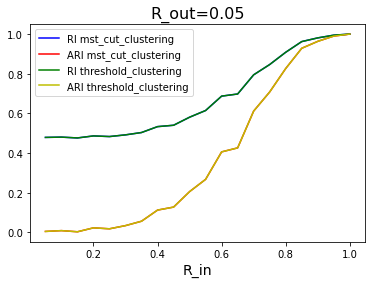

In [47]:
metrics = validation(true_labels, result, estimated_graphs_bags) 

In [ ]:
true_labels, result, estimated_graphs_bags = compute_clustering(rs, algos=[mst_cut_clustering], num_repeats=200, sample_vol=100)

Generating graphs started


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Generating graphs complete


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]

mst_cut_clustering complete


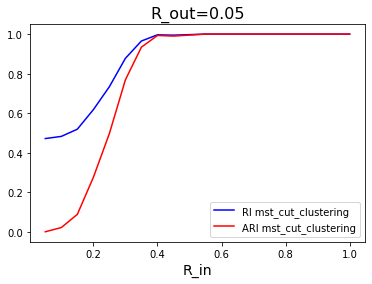

In [ ]:
metrics100 = validation(true_labels, result, estimated_graphs_bags) 

In [ ]:
df = pd.DataFrame(list(zip(rs[0], metrics['mst_cut_clustering']['ARI'], metrics20['mst_cut_clustering']['ARI'], metrics100['mst_cut_clustering']['ARI'])), columns = ['r_in', 'metrics10', 'metrics20', 'metrics100']).set_index(['r_in'])
df

,metrics10,metrics20,metrics100
r_in,,,
0.05,-0.003192,0.000508,-0.001126
0.10,-0.004180,0.002750,0.020330
0.15,0.008038,0.008563,0.087035
0.20,0.012288,0.013356,0.274392
0.25,0.026956,0.054296,0.496150
0.30,0.037274,0.085624,0.768310
0.35,0.054264,0.159150,0.933955
0.40,0.094961,0.227470,0.992985
0.45,0.123798,0.361943,0.990000


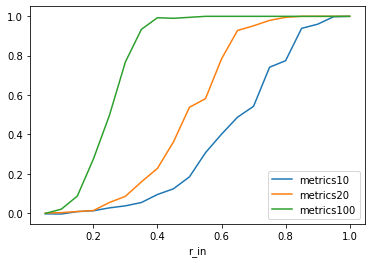

In [ ]:
df.plot()

In [ ]:
df= pd.DataFrame(nested_dict_to_dict(metrics))
df

mst_cut_clustering           threshold_clustering          
                   RI       ARI                   RI       ARI
0            0.475333  0.000327             0.475333  0.000327
1            0.477778  0.006021             0.477778  0.006021
2            0.480000  0.010766             0.480000  0.010766
3            0.484667  0.018186             0.484667  0.018186
4            0.485000  0.019912             0.485000  0.019912
5            0.487444  0.027853             0.487444  0.027853
6            0.518333  0.085711             0.518333  0.085711
7            0.516889  0.083474             0.516889  0.083474
8            0.542333  0.132554             0.542333  0.132554
9            0.555222  0.158022             0.555222  0.158022
10           0.577222  0.199111             0.577222  0.199111
11           0.670778  0.374257             0.670778  0.374257
12           0.722000  0.474024             0.722000  0.474024
13           0.798667  0.616935             0.798667  0.616935
14           0.832333  0.682238             0.832333  0.682238
15           0.922333  0.851620             0.922333  0.851620
16           0.965222  0.934456             0.965222  0.934456
17           0.990000  0.980970             0.990000  0.980970
18           1.000000  1.000000             1.000000  1.000000
19           1.000000  1.000000             1.000000  1.000000

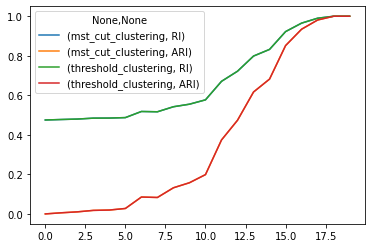

In [ ]:
df.plot()

In [ ]:
np.linalg.norm(np.array(metrics['mst_cut_clustering']['RI']) - np.array(metrics['threshold_clustering']['RI']))

0.0

In [50]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_repeats=200)

Generating graphs started


100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Generating graphs complete


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


spectral_clustering complete


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


normalized_spectral_clustering complete


100%|██████████| 20/20 [00:01<00:00, 10.84it/s]

louvain complete


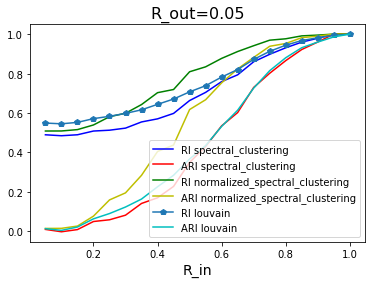

In [51]:
metrics = validation(true_labels, result, estimated_graphs_bags) 